In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *

# RIN criticality analysis

### Subject of analysis

In [3]:
prot = "7KVE_relaxed"
str_uni = "unidirectional"
unidirectional = True
str_inter = ""
filter_inter = False
path_data = "../data/igraph"

In [4]:
results_figs_path = "../figures/results"

### Dataset with everything!

Mutations, graph features, structural features, conservation score.

We'll use `df_mgsc` only in the first, pre-processing step.

In [5]:
df_mgsc, df_structure, df_conservation = read_all_data(prot = prot,
                                                       str_uni = str_uni, unidirectional = unidirectional,
                                                       str_inter = str_inter, filter_inter = filter_inter)


Graph is simple (no loops or multiple edges)

Everythings all right with the number of features!


### Graph features of RIN

This has the full RIN

In [6]:
# with preprocessing to remove irrelevant residues

graph_features_path = os.path.join(path_data, 'out', f"{prot}_graph_features_{str_uni}{str_inter}.csv")

df_graph_features = pd.read_csv(graph_features_path)

###############################################

df_graph_features = df_graph_features.query("betweenness != 0").copy()

###############################################

disconnected_res = [704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 
                    1536, 1538]

df_graph_features = df_graph_features.query(f"node not in {disconnected_res}").copy()

###############################################

# log betweenness
df_graph_features["log_betweenness"] = np.log10(df_graph_features["betweenness"])

print(df_graph_features.shape)

(1318, 9)


Calculating super_criticality

In [7]:
df_graph_features, lb_intervals, degree_intervals = calc_criticality(df_graph_features, 
                                                                     n_bins=4, 
                                                                     kind="uniform")

#####################################################

df_graph_features = calc_supercrit(df_graph_features)

#####################################################

df_graph_features = calc_criticality_super(df_graph_features)

None    1202
HDHB      63
LDLB      34
LDHB      19
Name: criticality, dtype: int64

## Dataset for the full rin + residues' attributes + conservation score

In [8]:
# full rin, residues' attributes and conservation score

bring_only_consv = [' POS', 'SCORE']

df_full = (df_graph_features.merge(df_structure, left_on="node", right_on="number", how="inner")
                            .merge(df_conservation[bring_only_consv], left_on="node", right_on=' POS'))

keys = ['node', ' POS', 'number']

df_full = df_full[keys + [x for x in df_full.columns if x not in keys]].copy()

print(f"\nShape of data: {df_full.shape}")

##########################

assert(df_graph_features.shape[0] == df_full.shape[0])


Shape of data: (1318, 21)


#### Target: whether or not residue was observed as a mutation

In [9]:
df_full["mutation_observed"] = 0

df_full.loc[df_full["node"].isin(df_mgsc["node"].unique()), "mutation_observed"] = 1

##########################

assert(df_full["mutation_observed"].sum() == df_mgsc["node"].unique().shape[0])

Distribution of taget:


0    95.22%
1     4.78%
Name: mutation_observed, dtype: object

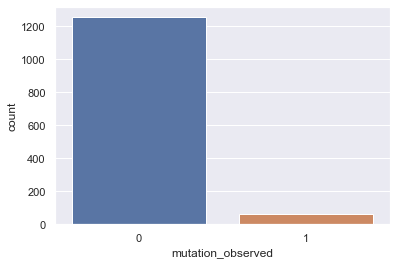

In [10]:
print("Distribution of taget:")

display(df_full["mutation_observed"].value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}%"))

sns.countplot(data = df_full, x = "mutation_observed")
plt.show()

In [11]:
# null data?
df_full.isnull().sum()

node                 0
 POS                 0
number               0
degree               0
betweenness          0
closeness            0
burt                 0
authority            0
page_rank            0
k_core               0
log_betweenness      0
criticality          0
supercritical        0
criticality_super    0
kdhydro              0
areaSAS              0
areaSES              0
phi                  0
psi                  1
relSESA              0
SCORE                0
mutation_observed    0
dtype: int64

In [12]:
df_full[df_full.isnull().any(axis=1)]

,node,POS,number,degree,betweenness,closeness,burt,authority,page_rank,k_core,...,supercritical,criticality_super,kdhydro,areaSAS,areaSES,phi,psi,relSESA,SCORE,mutation_observed
65,2196,2196,2196,3,25516.290319,0.111612,0.402971,0.010402,0.000397,3,...,False,LDHB,-1.3,142.272525,160.979535,-129.971459,NaN,1.229931,-0.25,0


In [13]:
# dropping row with missing phi (it's the last residue)

df_full = df_full[~df_full.isna().any(axis=1)]

In [14]:
X = df_full[['degree', 'closeness', 'burt', 'authority', 'page_rank', 'k_core', 'log_betweenness',
             'kdhydro', 'areaSAS', 'areaSES', 'phi', 'psi', 'relSESA',
             'SCORE']]

y = df_full["mutation_observed"]

In [15]:
X.shape

(1317, 14)

In [16]:
y.value_counts()

0    1254
1      63
Name: mutation_observed, dtype: int64

_________

### Saving the supervised dataset

In [17]:
pd.concat([X, y], axis=1).to_csv("../data/final_supervised_dataset_mutation.csv", index=False)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   degree           1317 non-null   int64  
 1   closeness        1317 non-null   float64
 2   burt             1317 non-null   float64
 3   authority        1317 non-null   float64
 4   page_rank        1317 non-null   float64
 5   k_core           1317 non-null   int64  
 6   log_betweenness  1317 non-null   float64
 7   kdhydro          1317 non-null   float64
 8   areaSAS          1317 non-null   float64
 9   areaSES          1317 non-null   float64
 10  phi              1317 non-null   float64
 11  psi              1317 non-null   float64
 12  relSESA          1317 non-null   float64
 13  SCORE            1317 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 154.3 KB


We only have numeric features! So, no categorical encoding will be necessary.

___________

Paper figure - criticality in Degree vs Log-Betweenness space

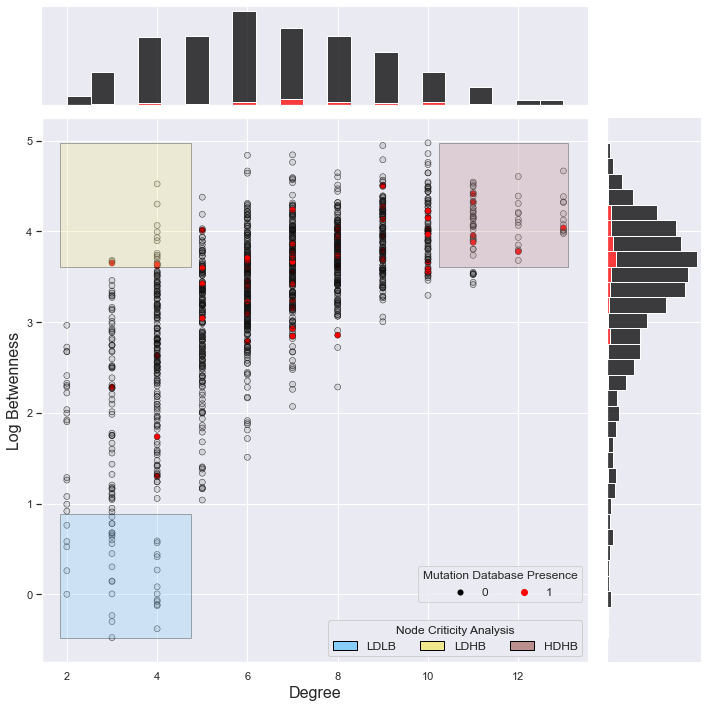

In [19]:
plot_criticality_pretty(pd.concat([X, y], axis=1), results_figs_path)

___________

## Modeling

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


estimators = {"dt" : DecisionTreeClassifier(random_state=42, class_weight="balanced"),
              "rf" : RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
              "xgb" : XGBClassifier(random_state=42, use_label_encoder=False,
                                    n_jobs=-1, eval_metric='logloss', 
                                    scale_pos_weight = y.value_counts()[0]/y.value_counts()[1]),
              "svm" : SVC(random_state=42, max_iter=10000, class_weight="balanced"),
              "knn" : KNeighborsClassifier(n_jobs=-1)
             }

param_grids = {"dt" : {"dt__criterion" : ["entropy", "gini"],
                       "dt__min_samples_split" : range(2, 51),
                       "dt__min_samples_leaf" : range(1, 21),
                       "dt__ccp_alpha" : [1/(10**x) for x in range(5)]
                      },
              # =============================================================
              "rf" : {"rf__n_estimators" : range(50, 1550, 50),
                      "rf__max_features" : range(2, 8),
                      "rf__min_samples_leaf" : range(1, 11)},
              # =============================================================
              "xgb" : {"xgb__max_depth" : range(1, 26),
                       "xgb__reg_lambda" : [1/(10**x) for x in range(5)], 
                       "xgb__learning_rate" : [1/(10**x) for x in range(5)]},
              # =============================================================
              "svm" : {"svm__kernel" : ['poly', 'rbf'],
                       "svm__gamma" : np.arange(0.01, 1.5+0.05, 0.05),
                       "svm__degree" : range(2, 6),
                       "svm__coef0" : np.arange(0.1, 2+0.05, 0.05)},
              # =============================================================
              "knn" : {"knn__n_neighbors" : range(3, 51)}
              }

print("Total number of models to be fit for each estimator:\n")
print({estmtr : np.prod([len(v) for v in grid.values()]) for estmtr, grid in param_grids.items()})

Total number of models to be fit for each estimator:

{'dt': 9800, 'rf': 1800, 'xgb': 625, 'svm': 9672, 'knn': 48}


__________

## Quick test - baseline models (with default HPs, no PCA, no oversampling)



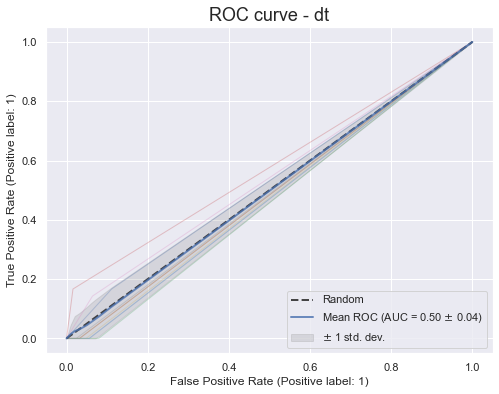



# ================================================================================ #




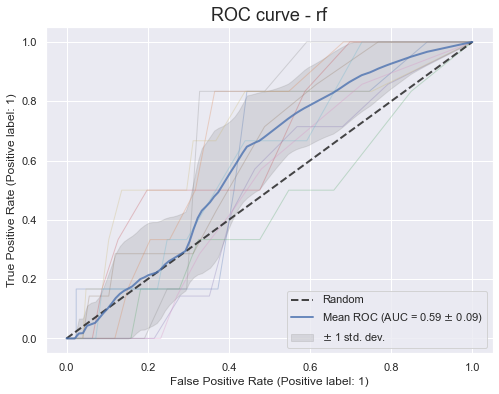



# ================================================================================ #




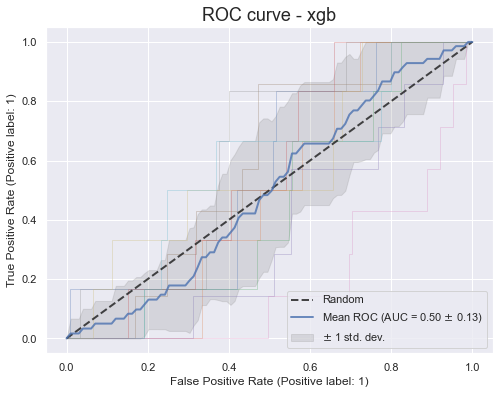



# ================================================================================ #




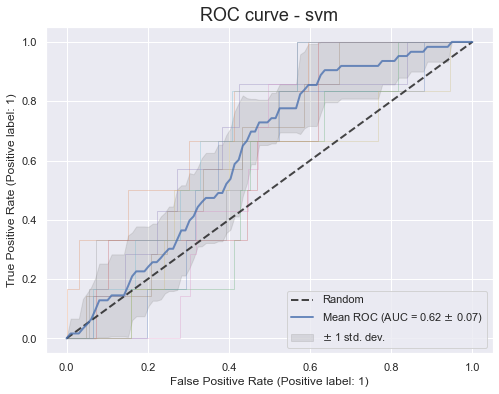



# ================================================================================ #




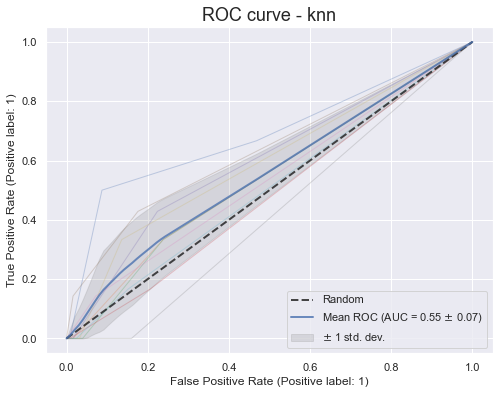



# ================================================================================ #




In [21]:
for estimator_label, estimator in estimators.items():
    
    pipe = Pipeline([("ss", StandardScaler()),
                     (estimator_label, estimator)])
    
    plot_cv_roc_from_estimator(pipe, estimator_label, X, y)
    
    print("\n")
    print(f"# {'='*80} #")
    print("\n")

________

## Now, let's begin with the grid searchs!

In [22]:
# list of dataframes with results (all of them)
results_grid_list = []

# list of dataframes with results of best model
results_best_list = []

**IMPORTANT**:

The code was already run, and the results are in the folders `../data/grid_cv_results/` and `../models/intermediate_best_models/`. For this reason, the code below will only read these files. If you wish to re-run everything, just delete the result files in the aforementioned folders, and run the code below. Notice that it may take a while to run the full grid.

### No PCA, no oversampling.

In [23]:
results_df_stmtr, results_best = modeling_pipeline("dt", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

# split cells in the prints when you run the pipeline for the first time
# (i.e., when the files with the results haven't yet been created)
# because it may take too long to run the full gridsearch, so it's better
# to run the grid for each model separately
print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("rf", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("xgb", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("svm", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("knn", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)


Grid results read for dt!

# ==================================================== #

Grid results read for rf!

# ==================================================== #

Grid results read for xgb!

# ==================================================== #

Grid results read for svm!

# ==================================================== #

Grid results read for knn!


### No PCA, with ADASYN oversampling.

In [24]:
results_df_stmtr, results_best = modeling_pipeline("dt", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample="adasyn")

results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("rf", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("xgb", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("svm", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("knn", estimators, param_grids, X, y,
                                                   encoding=False, pca=False, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)


Grid results read for dt!

# ==================================================== #

Grid results read for rf!

# ==================================================== #

Grid results read for xgb!

# ==================================================== #

Grid results read for svm!

# ==================================================== #

Grid results read for knn!


__________

### With PCA, no oversampling.

In [25]:
results_df_stmtr, results_best = modeling_pipeline("dt", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("rf", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("xgb", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("svm", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("knn", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample=False)
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)


Grid results read for dt!

# ==================================================== #

Grid results read for rf!

# ==================================================== #

Grid results read for xgb!

# ==================================================== #

Grid results read for svm!

# ==================================================== #

Grid results read for knn!


### With PCA, with ADASYN oversampling.

In [26]:
results_df_stmtr, results_best = modeling_pipeline("dt", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample="adasyn")

results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("rf", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("xgb", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("svm", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)

print("\n# ==================================================== #")

results_df_stmtr, results_best = modeling_pipeline("knn", estimators, param_grids, X, y,
                                                   encoding=False, pca=True, pct_var_exp=0.85, oversample="adasyn")
results_grid_list.append(results_df_stmtr)
results_best_list.append(results_best)


Grid results read for dt!

# ==================================================== #

Grid results read for rf!

# ==================================================== #

Grid results read for xgb!

# ==================================================== #

Grid results read for svm!

# ==================================================== #

Grid results read for knn!


_______

__________

#### Let's analyse model results

In [27]:
results_grid = pd.concat(results_grid_list).sort_values("mean_test_score", ascending=False).reset_index(drop=True)

results_best = pd.concat(results_best_list).sort_values("mean_test_score", ascending=False).reset_index(drop=True)

In [28]:
results_best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,estimator,encoding,pca,oversample,best_model_path
0,0.083433,0.006827,0.011010,0.005595,"{'svm__coef0': 1.8500000000000008, 'svm__degre...",0.615079,0.783069,0.596561,0.862434,0.621714,...,0.578667,0.825333,0.687124,0.095430,1,svm,False,True,False,../models/intermediate_best_models/best_svm_on...
1,0.444788,0.032000,0.015152,0.009011,"{'svm__coef0': 2.0000000000000004, 'svm__degre...",0.591270,0.843915,0.652116,0.629630,0.704000,...,0.614667,0.729333,0.679788,0.080168,1,svm,False,True,adasyn,../models/intermediate_best_models/best_svm_on...
2,0.089826,0.007281,0.010202,0.008139,"{'svm__coef0': 0.5000000000000001, 'svm__degre...",0.617725,0.816138,0.667989,0.785714,0.606857,...,0.508000,0.788000,0.665880,0.105472,1,svm,False,False,False,../models/intermediate_best_models/best_svm_on...
3,0.407922,0.015276,0.008743,0.008213,"{'xgb__learning_rate': 0.01, 'xgb__max_depth':...",0.604497,0.810847,0.654101,0.767857,0.549714,...,0.600667,0.743333,0.656654,0.101677,1,xgb,False,False,False,../models/intermediate_best_models/best_xgb_on...
4,0.381883,0.020591,0.018534,0.007434,"{'svm__coef0': 0.20000000000000004, 'svm__degr...",0.652116,0.837302,0.608466,0.690476,0.682286,...,0.536000,0.722667,0.656455,0.093536,1,svm,False,False,adasyn,../models/intermediate_best_models/best_svm_on...
5,0.281164,0.069470,0.035151,0.012844,"{'rf__max_features': 4, 'rf__min_samples_leaf'...",0.638889,0.644180,0.597884,0.765873,0.536000,...,0.649333,0.773333,0.650663,0.083644,1,rf,False,False,False,../models/intermediate_best_models/best_rf_onl...
6,0.058509,0.008235,0.006989,0.007826,"{'dt__ccp_alpha': 0.0001, 'dt__criterion': 'gi...",0.654762,0.701058,0.671296,0.747354,0.616000,...,0.503333,0.643333,0.649304,0.067050,1,dt,False,False,adasyn,../models/intermediate_best_models/best_dt_onl...
7,0.049471,0.007681,0.075657,0.025566,{'knn__n_neighbors': 50},0.679894,0.777778,0.560185,0.578042,0.601143,...,0.670667,0.700667,0.649057,0.063540,1,knn,False,True,adasyn,../models/intermediate_best_models/best_knn_on...
8,0.835762,0.140796,0.187825,0.143095,"{'rf__max_features': 2, 'rf__min_samples_leaf'...",0.695767,0.808201,0.681217,0.792328,0.510857,...,0.669333,0.489333,0.646628,0.103424,1,rf,False,True,adasyn,../models/intermediate_best_models/best_rf_onl...
9,2.767643,0.170298,0.011976,0.000806,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",0.706349,0.804233,0.710317,0.718254,0.553143,...,0.629333,0.545333,0.646011,0.097214,1,xgb,False,True,adasyn,../models/intermediate_best_models/best_xgb_on...


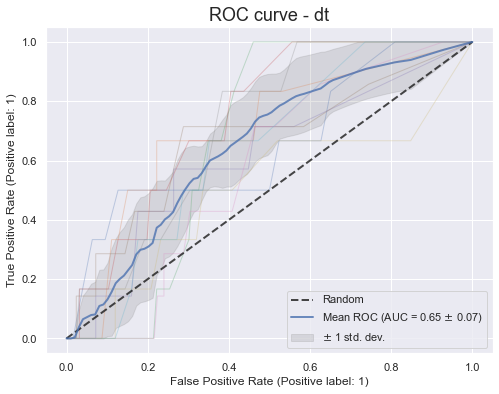

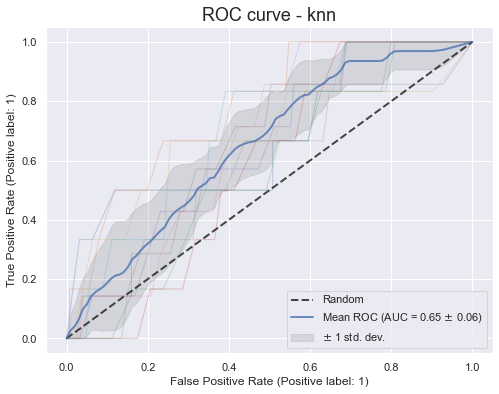

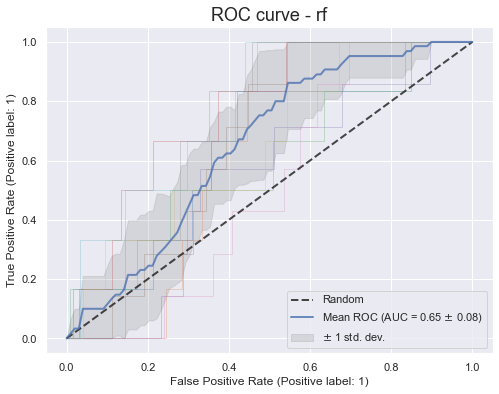

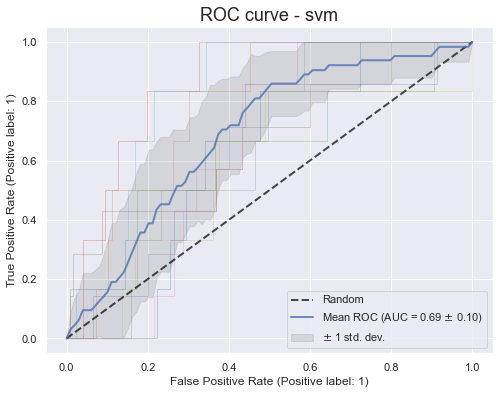

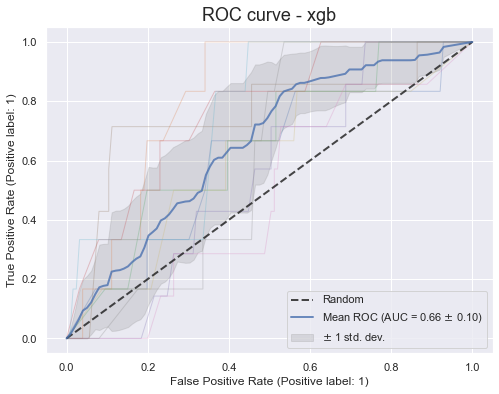

In [29]:
pipelines_best_hps = get_best_pipelines(X, y, results_best)

for estimator_label, pipe in pipelines_best_hps.items():
    
    plot_cv_roc_from_estimator(pipe, estimator_label, X, y) 

In [30]:
pipelines_best_hps

{'dt': Pipeline(steps=[('pre_process',
                  ColumnTransformer(transformers=[('transf_num',
                                                   Pipeline(steps=[('std_scaler',
                                                                    StandardScaler())]),
                                                   ['degree', 'closeness',
                                                    'burt', 'authority',
                                                    'page_rank', 'k_core',
                                                    'log_betweenness', 'kdhydro',
                                                    'areaSAS', 'areaSES', 'phi',
                                                    'psi', 'relSESA',
                                                    'SCORE'])])),
                 ('adasyn', ADASYN(random_state=42)),
                 ('dt',
                  DecisionTreeClassifier(ccp_alpha=0.0001,
                                         class_weight='balanced',


This object contains a dictionary of the best models, which are the final ones used to produce the reported predictions.

In [31]:
dump(pipelines_best_hps, "../models/dict_best_models.joblib")

['../models/dict_best_models.joblib']

In [32]:
pipelines_best_hps.keys()

dict_keys(['dt', 'knn', 'rf', 'svm', 'xgb'])

In [33]:
models = pipelines_best_hps.values()
labels = ["dt", "knn", "rf", "svm", "xgb"]

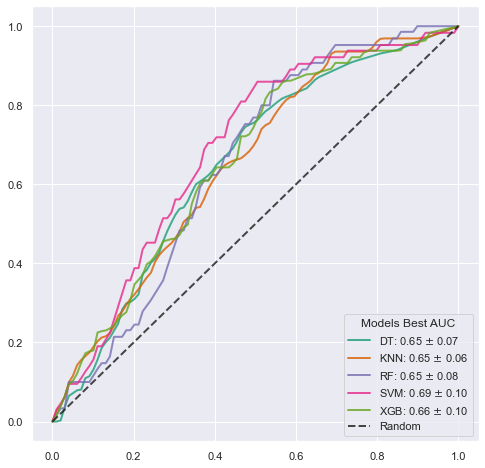

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

for model, label, color in zip(models, labels, cm.Dark2.colors):
    create_roc_curve(X, y, model, ax, label, color)
    
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="Random", alpha=0.8)
ax.legend(loc="lower right", title="Models Best AUC")
plt.savefig(f"{results_figs_path}/models_best_aucs.svg", format="svg")
plt.show()

___________
___________
___________
___________
___________
___________
___________
___________
___________
___________
___________
___________
